# Business Case 3 - Recommender System

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

## Importing Libraries and Dataset

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from datetime import datetime
# %pip install abc_analysis
from abc_analysis import abc_analysis
from mlxtend.frequent_patterns import apriori, association_rules
from tabulate import tabulate

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

In [86]:
data = pd.read_csv("retail.csv")
data_orig = data.copy()
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [87]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Year"] = data["InvoiceDate"].dt.year
data["Month"] = data["InvoiceDate"].dt.month
# data["MonthName"] = data["InvoiceDate"].dt.month_name()
data["Day"] = data["InvoiceDate"].dt.day
data["Weekday"] = data["InvoiceDate"].dt.weekday +1
data["WeekdayName"] = data["InvoiceDate"].dt.day_name()
data["IsWeekend"] = data["Weekday"] > 5
data["Time"] = data["InvoiceDate"].dt.time
data["Hour"] = data["InvoiceDate"].dt.hour
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Year         541909 non-null  int64         
 9   Month        541909 non-null  int64         
 10  Day          541909 non-null  int64         
 11  Weekday      541909 non-null  int64         
 12  WeekdayName  541909 non-null  object        
 13  IsWeekend    541909 non-null  bool          
 14  Time         541909 non-null  object        
 15  Hour         541909 non-null  int6

In [88]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
prods['session'] = pd.cut(prods['hour'], bins=b, labels=l, include_lowest=True)

data["DayTime"] = data['Hour'].apply(f)

In [89]:
prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
prods['session'] = pd.cut(prods['hour'], bins=b, labels=l, include_lowest=True)

In [90]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0
Year,541909.0,2010.921609,0.268787,2010.00,2011.00,2011.00,2011.00,2011.0
Month,541909.0,7.553128,3.509055,1.00,5.00,8.00,11.00,12.0
Day,541909.0,15.023096,8.664063,1.00,7.00,15.00,22.00,31.0
Weekday,541909.0,3.431277,1.844709,1.00,2.00,3.00,5.00,7.0
Hour,541909.0,13.078729,2.443270,6.00,11.00,13.00,15.00,20.0


## Data exploration

Business understanding

In [91]:
#Counting the important features to have the notion of the dimension
print('The number of countries is:', data.Country.nunique())
print('The number of customers with observations is:', data.CustomerID.nunique())
print('The number of Products with transactions is:', data.Description.nunique())

The number of countries is: 38
The number of customers with observations is: 4372
The number of Products with transactions is: 4223


In [92]:
table1 = [['N. Countries', 'N. customers', 'N. Products'],[data.Country.nunique(), data.CustomerID.nunique(), data.Description.nunique()]]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════╤════════════════╤═══════════════╕
│   N. Countries │   N. customers │   N. Products │
╞════════════════╪════════════════╪═══════════════╡
│             38 │           4372 │          4223 │
╘════════════════╧════════════════╧═══════════════╛


In [93]:
def boxplot (data):
    from math import ceil

    metric_features = data.select_dtypes(include=np.number).set_index(data.index).columns
    sns.set()
    
    fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

    
    for ax, feat in zip(axes.flatten(), metric_features): 

        sns.boxplot(x = data[feat], ax = ax)
        

    
    title = "Numeric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

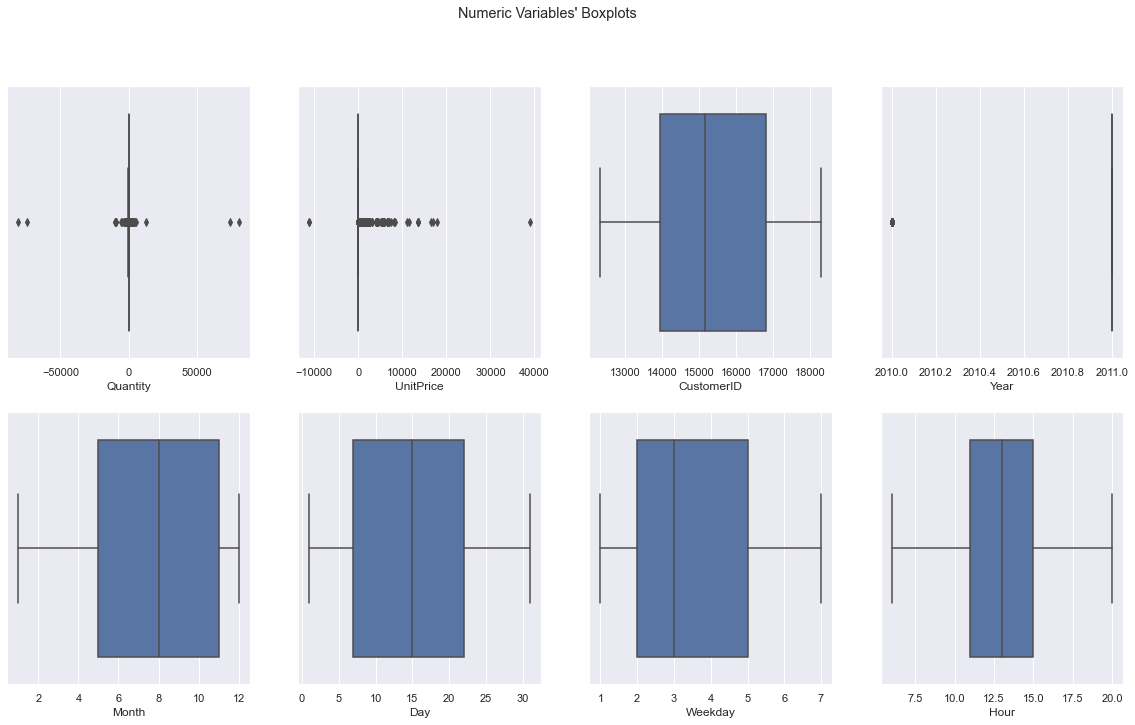

In [94]:
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
boxplot(data[numeric_features])

In [95]:
#removing "outliers"
data = data[data["Quantity"]<10000]
data = data[data["UnitPrice"]<600]

Cancelations

In [96]:
cancelations = data.loc[data["InvoiceNo"].str.contains("C")]
cancelations

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,12,1,3,Wednesday,False,09:41:00,9,Morning
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,12,1,3,Wednesday,False,09:49:00,9,Morning
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,1,3,Wednesday,False,10:24:00,10,Morning
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,3,Wednesday,False,10:24:00,10,Morning
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,3,Wednesday,False,10:24:00,10,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,2011,12,9,5,Friday,False,09:57:00,9,Morning
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,2011,12,9,5,Friday,False,10:28:00,10,Morning
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,2011,12,9,5,Friday,False,11:57:00,11,Morning
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,2011,12,9,5,Friday,False,11:58:00,11,Morning


In [97]:
#check consistency for cancelations, we shouldnt have any cancelations with quantity > 0
cancelations.loc[cancelations["Quantity"] > 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime


In [98]:
#check if for cancellations we have also the non cancelled record
cancelations2 = cancelations.copy()

#deleting C into cancelled invoices to have a joinable column to original df
cancelations2["InvoiceNo"] = cancelations2["InvoiceNo"].str.replace("C", "")

#results finds 0 records --> no duplicated records
pd.merge(left = data, right = cancelations2, how = "inner", on = "InvoiceNo")

,InvoiceNo,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Year_x,Month_x,...,Country_y,Year_y,Month_y,Day_y,Weekday_y,WeekdayName_y,IsWeekend_y,Time_y,Hour_y,DayTime_y


In [99]:
#removing from dataset cancelations
data = data[data["Quantity"] >= 0]

Missing values

In [100]:
data.isna().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133274
Country             0
Year                0
Month               0
Day                 0
Weekday             0
WeekdayName         0
IsWeekend           0
Time                0
Hour                0
DayTime             0
dtype: int64

In [101]:
#showing records not having customer id
data[data.CustomerID.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,2010,12,1,3,Wednesday,False,11:52:00,11,Morning
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541535,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning


In [102]:
# number of invoices not having at least one missing customer id value
len(data[data.CustomerID.isna()]["InvoiceNo"].unique())

2182

Data Consistency

In [103]:
#checking dataset consistency - for each invoice only one customer id associated
grouped = data.groupby("InvoiceNo")["CustomerID"].nunique(dropna=False)
grouped.sort_values(ascending = False)

InvoiceNo
536365     1
566874     1
566829     1
566823     1
566822     1
          ..
551944     1
551907     1
551902     1
551900     1
A563187    1
Name: CustomerID, Length: 20695, dtype: int64

In [104]:
#checking dataset consistency - for each stock code only one description associated
grouped = data.groupby("StockCode")["Description"].nunique(dropna=False)
grouped.sort_values(ascending = False)

StockCode
23084     7
20713     7
22734     5
21181     5
85135B    4
         ..
22526     1
22528     1
22529     1
22530     1
m         1
Name: Description, Length: 3940, dtype: int64

In [105]:
# by looking at results we decide not to take care of this issue, we just use stock code
data[data["StockCode"] == "20713"]["Description"].unique()

array(['JUMBO BAG OWLS', nan, 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

Taking care of stock codes not associated to products

In [106]:
print("Value counts of StockCodes with string lenght minor than 5")
print(data[data["StockCode"].str.len()<5].value_counts("StockCode"))
print()
print("Description associated")
print(data[data["StockCode"].str.len()<5].value_counts("Description"))

Value counts of StockCodes with string lenght minor than 5
StockCode
POST    1128
DOT      625
M        296
C2       142
PADS       4
B          2
S          2
m          1
dtype: int64

Description associated
Description
POSTAGE                       1124
DOTCOM POSTAGE                 624
Manual                         297
CARRIAGE                       141
PADS TO MATCH ALL CUSHIONS       4
Adjust bad debt                  2
SAMPLES                          2
dtype: int64


In [107]:
# deleting stock codes with len < 5 ()
del_stockcodes = data[data["StockCode"].str.len()<5].StockCode.unique().tolist()
data = data[~data["StockCode"].isin(del_stockcodes)]

Items with price associated 0

In [108]:
# quick look on invoices having cost 0
data[data.UnitPrice == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,11:52:00,11,Morning
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:33:00,14,Noon
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:33:00,14,Noon
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:34:00,14,Noon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,2011-12-07 18:36:00,0.0,NaN,United Kingdom,2011,12,7,3,Wednesday,False,18:36:00,18,Eve
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,2011,12,8,4,Thursday,False,10:33:00,10,Morning
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom,2011,12,8,4,Thursday,False,13:58:00,13,Noon
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom,2011,12,8,4,Thursday,False,13:58:00,13,Noon


In [109]:
#number of products having unit price to 0
print("# of rows having price 0 : ", len(data[data.UnitPrice == 0]))
print("# of products having price 0 : ", len(data[data.UnitPrice == 0]["StockCode"].unique()))

# of rows having price 0 :  1163
# of products having price 0 :  675


In [110]:
#Reducing cardinality for Country
data.loc[data["Country"].value_counts()[data["Country"]].values < 500, "Country"] = "Others"

Duplicates

In [111]:
data_dup = data.copy()
print("Percentage of suspect duplicated data: " , (data_orig.duplicated(["StockCode", "InvoiceNo"]).sum() / len(data)) * 100)

Percentage of suspect duplicated data:  2.01980864373744


In [112]:
duplicates = data_dup.loc[data_dup.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
1596,19,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
1595,11,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
3170,7,572861,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-10-26 12:46:00,1.25,14102.0,United Kingdom,2011,10,26,3,Wednesday,False,12:46:00,12,Morning
346,5,538514,21756,BATH BUILDING BLOCK WORD,1,2010-12-12 14:27:00,5.95,15044.0,United Kingdom,2010,12,12,7,Sunday,True,14:27:00,14,Noon
470,5,540524,21756,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735.0,United Kingdom,2011,1,9,7,Sunday,True,12:53:00,12,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,1,556280,22500,SET OF 2 TINS JARDIN DE PROVENCE,1,2011-06-09 20:03:00,4.95,14584.0,United Kingdom,2011,6,9,4,Thursday,False,20:03:00,20,Eve
1658,1,556280,22497,SET OF 2 TINS VINTAGE BATHROOM,1,2011-06-09 20:03:00,4.25,14584.0,United Kingdom,2011,6,9,4,Thursday,False,20:03:00,20,Eve
1657,1,556263,23242,TREASURE TIN BUFFALO BILL,1,2011-06-09 18:41:00,2.08,13969.0,United Kingdom,2011,6,9,4,Thursday,False,18:41:00,18,Eve
1656,1,556252,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2011-06-09 16:44:00,0.85,16779.0,United Kingdom,2011,6,9,4,Thursday,False,16:44:00,16,Noon


In [113]:
data[(data.InvoiceNo == "555524") & (data.StockCode == "22698")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
213176,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213177,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213183,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213191,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213192,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213194,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213195,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213196,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213197,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213198,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning


In [114]:
#replacing duplicates with single record containing sum of all quantities for records that are going to be deleted
# tested, it works
data['Quantity'] = data.groupby(['InvoiceNo', 'StockCode'])['Quantity'].transform('sum')
data = data.drop_duplicates(subset=['InvoiceNo', 'StockCode'])

In [115]:
data[(data.InvoiceNo == "555524") & (data.StockCode == "22698")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
213176,555524,22698,PINK REGENCY TEACUP AND SAUCER,20,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning


In [116]:
data["TotalPrice"] = data["UnitPrice"] * data["Quantity"]

ABC segmentation

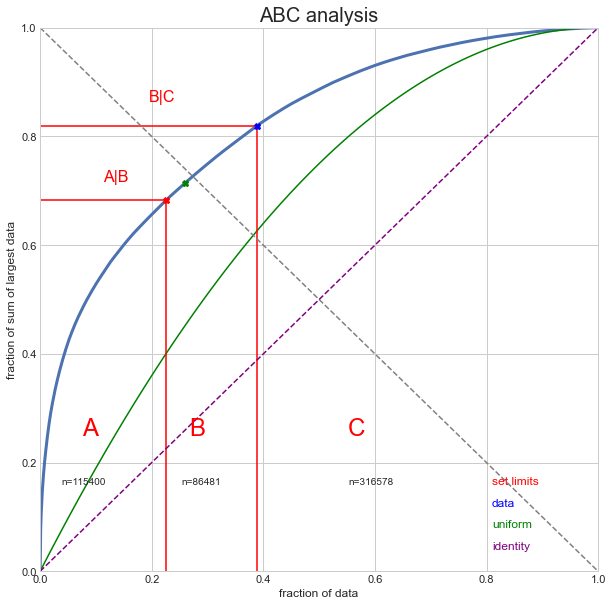

{'ABLimit': 19.5,
 'BCLimit': 14.040000000000001,
 'ABexchanged': True,
 'Aind': [1,
  2,
  3,
  4,
  6,
  9,
  12,
  14,
  16,
  19,
  20,
  21,
  26,
  27,
  28,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  39,
  40,
  41,
  44,
  45,
  49,
  50,
  51,
  57,
  60,
  61,
  63,
  64,
  66,
  67,
  68,
  74,
  77,
  78,
  80,
  81,
  82,
  87,
  89,
  90,
  95,
  100,
  101,
  104,
  105,
  106,
  110,
  111,
  137,
  138,
  140,
  141,
  143,
  144,
  145,
  147,
  148,
  149,
  150,
  152,
  153,
  155,
  156,
  157,
  159,
  162,
  163,
  164,
  166,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  185,
  190,
  191,
  192,
  193,
  194,
  196,
  197,
  198,
  205,
  206,
  208,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  235,
  238,
  239,
  241,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  258,
  261,
  262,
  263,
  264,
  265,
 

In [117]:
abc_transactions = abc_analysis(data["TotalPrice"], True, fltSize=10)

# index position of A, B, and C for transactions
transaction_a_index = abc_transactions['Aind']
transaction_b_index = abc_transactions['Bind']
transaction_c_index = abc_transactions['Cind']

# New Column indicating A, B, or C
condition = [data.index.isin(transaction_a_index),
             data.index.isin(transaction_b_index),
             data.index.isin(transaction_c_index)]

segment_list = ['A','B','C']

data['Transaction_ABC'] = np.select(condition, segment_list)
data.sort_values(by=['TotalPrice'], ascending=True)
abc_transactions

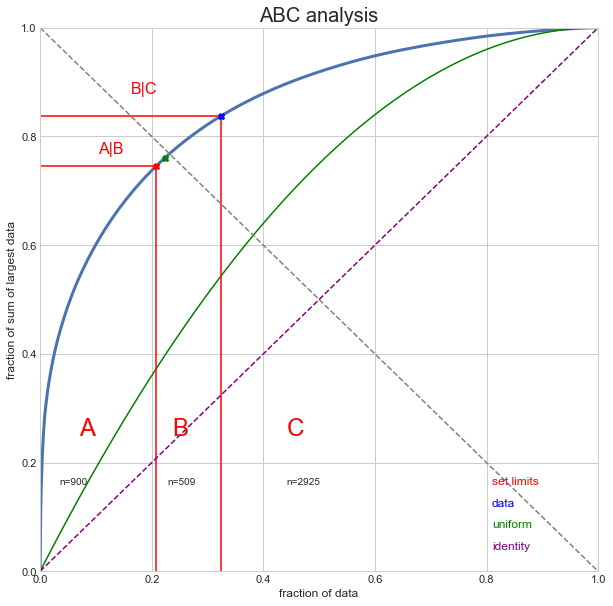

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice,Transaction_ABC,Customer_ABC
41492,539856,22372,AIRLINE BAG VINTAGE WORLD CHAMPION,1,2010-12-22 14:41:00,0.00,NaN,United Kingdom,2010,12,22,3,Wednesday,False,14:41:00,14,Noon,0.00,C,0
299545,563106,21658,NaN,3,2011-08-12 10:15:00,0.00,NaN,United Kingdom,2011,8,12,5,Friday,False,10:15:00,10,Morning,0.00,C,0
175253,551900,20778,NaN,2,2011-05-05 10:45:00,0.00,NaN,United Kingdom,2011,5,5,4,Thursday,False,10:45:00,10,Morning,0.00,C,0
160541,550460,47556B,did a credit and did not tick ret,1300,2011-04-18 13:18:00,0.00,NaN,United Kingdom,2011,4,18,1,Monday,False,13:18:00,13,Noon,0.00,A,0
299550,563108,21033,NaN,37,2011-08-12 10:18:00,0.00,NaN,United Kingdom,2011,8,12,5,Friday,False,10:18:00,10,Morning,0.00,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,2011,1,11,2,Tuesday,False,12:55:00,12,Morning,4921.50,C,A
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,2011,10,27,4,Thursday,False,12:11:00,12,Morning,4992.00,A,A
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,2011,1,11,2,Tuesday,False,12:55:00,12,Morning,6539.40,C,A
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,2011,4,18,1,Monday,False,13:20:00,13,Noon,6539.40,C,A


In [118]:
customer_values = data[["CustomerID", "TotalPrice"]].groupby("CustomerID").sum("TotalPrice").sort_values("TotalPrice", ascending = False)
abc_customers = abc_analysis(customer_values["TotalPrice"], True, fltSize=10)

# index position of A, B, and C for transactions
customer_a_index = customer_values.iloc[abc_customers['Aind']].index
customer_b_index = customer_values.iloc[abc_customers['Bind']].index
customer_c_index = customer_values.iloc[abc_customers['Cind']].index

# New Column indicating A, B, or C
condition = [data["CustomerID"].isin(customer_a_index),
             data["CustomerID"].isin(customer_b_index),
             data["CustomerID"].isin(customer_c_index)]

segment_list = ['A','B','C']

data['Customer_ABC'] = np.select(condition, segment_list)
data.sort_values(by=['TotalPrice'], ascending=True)

# BEWARE WE HAVE SOME NaNs for these values --> might not be the most accurate classification

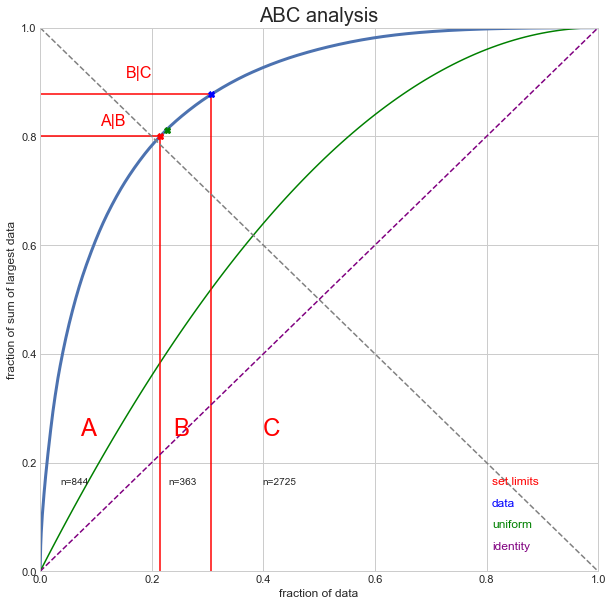

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,...,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice,Transaction_ABC,Customer_ABC,Product_ABC
41492,539856,22372,AIRLINE BAG VINTAGE WORLD CHAMPION,1,2010-12-22 14:41:00,0.00,NaN,United Kingdom,2010,12,...,3,Wednesday,False,14:41:00,14,Noon,0.00,C,0,C
299545,563106,21658,NaN,3,2011-08-12 10:15:00,0.00,NaN,United Kingdom,2011,8,...,5,Friday,False,10:15:00,10,Morning,0.00,C,0,A
175253,551900,20778,NaN,2,2011-05-05 10:45:00,0.00,NaN,United Kingdom,2011,5,...,4,Thursday,False,10:45:00,10,Morning,0.00,C,0,C
160541,550460,47556B,did a credit and did not tick ret,1300,2011-04-18 13:18:00,0.00,NaN,United Kingdom,2011,4,...,1,Monday,False,13:18:00,13,Noon,0.00,A,0,A
299550,563108,21033,NaN,37,2011-08-12 10:18:00,0.00,NaN,United Kingdom,2011,8,...,5,Friday,False,10:18:00,10,Morning,0.00,C,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,2011,1,...,2,Tuesday,False,12:55:00,12,Morning,4921.50,C,A,A
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,2011,10,...,4,Thursday,False,12:11:00,12,Morning,4992.00,A,A,A
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,2011,1,...,2,Tuesday,False,12:55:00,12,Morning,6539.40,C,A,A
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,2011,4,...,1,Monday,False,13:20:00,13,Noon,6539.40,C,A,A


In [119]:
product_values = data[["TotalPrice", "StockCode"]].groupby("StockCode").sum("TotalPrice").sort_values("TotalPrice", ascending = False)
abc_products = abc_analysis(product_values["TotalPrice"], True, fltSize=10)

# # # index position of A, B, and C for transactions
product_a_index = product_values.iloc[abc_products['Aind']].index
product_b_index = product_values.iloc[abc_products['Bind']].index
product_c_index = product_values.iloc[abc_products['Cind']].index

# # New Column indicating A, B, or C
condition = [data["StockCode"].isin(product_a_index),
             data["StockCode"].isin(product_b_index),
             data["StockCode"].isin(product_c_index)]

segment_list = ['A','B','C']

data['Product_ABC'] = np.select(condition, segment_list)
data.sort_values(by=['TotalPrice'], ascending=True)

## A priori algorithm

In [120]:
basket = (data.groupby(['InvoiceNo', 'StockCode'])['Quantity']
        .sum().unstack().reset_index().fillna(0)
        .set_index('InvoiceNo'))
basket

# Transactions done in France
basket_France = (data[data['Country'] =="France"]
        .groupby(['InvoiceNo', 'StockCode'])['Quantity']
        .sum().unstack().reset_index().fillna(0)
        .set_index('InvoiceNo'))

In [121]:
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# basket = basket.applymap(hot_encode)
# basket
basket_France = basket_France.applymap(hot_encode)

In [122]:
# frq_items = apriori(basket, min_support = 0.03, use_colnames = True)
frq_items = apriori(basket_France, min_support = 0.05, use_colnames = True)

In [123]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

rules.head(16)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
68,"(21086, 21080)",(21094),0.104712,0.130890,0.102094,0.975000,7.449000,0.088388,34.764398
69,"(21094, 21080)",(21086),0.104712,0.141361,0.102094,0.975000,6.897222,0.087292,34.345550
25,(21094),(21086),0.130890,0.141361,0.125654,0.960000,6.791111,0.107152,21.465969
66,(23256),(23254),0.070681,0.073298,0.065445,0.925926,12.632275,0.060264,12.510471
34,(21988),(21987),0.057592,0.065445,0.052356,0.909091,13.890909,0.048587,10.280105
67,(23254),(23256),0.073298,0.070681,0.065445,0.892857,12.632275,0.060264,8.673647
24,(21086),(21094),0.141361,0.130890,0.125654,0.888889,6.791111,0.107152,7.821990
80,"(22726, 22728)",(22727),0.075916,0.096859,0.065445,0.862069,8.900280,0.058092,6.547775
82,"(22728, 22727)",(22726),0.075916,0.099476,0.065445,0.862069,8.666062,0.057893,6.528796
61,(22727),(22726),0.096859,0.099476,0.081152,0.837838,8.422475,0.071517,5.553229


In [124]:
len(rules)

86

# Suggestion Models

## Part 1

In [83]:
popular_products = pd.DataFrame(data.groupby('StockCode')['Quantity'].sum())
most_popular = popular_products.sort_values('Quantity', ascending=False)
most_popular.head(10)

,Quantity
StockCode,
22197,56921
84077,55047
85099B,48478
85123A,41664
84879,36461
21212,36419
23084,31722
22492,26633
22616,26339


<AxesSubplot:xlabel='StockCode'>

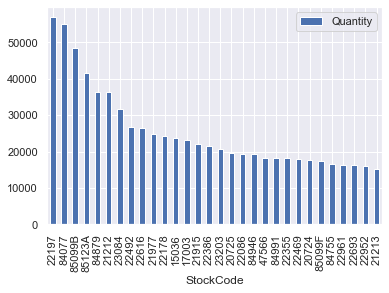

In [84]:
most_popular.head(30).plot(kind = "bar")

In [85]:
popular_products = pd.DataFrame(data.groupby('Description')['Quantity'].sum())
most_popular = popular_products.sort_values('Quantity', ascending=False)
most_popular.head(10)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
JUMBO BAG RED RETROSPOT,48478
WHITE HANGING HEART T-LIGHT HOLDER,37895
POPCORN HOLDER,36761
ASSORTED COLOUR BIRD ORNAMENT,36461
PACK OF 72 RETROSPOT CAKE CASES,36419
RABBIT NIGHT LIGHT,30788
MINI PAINT SET VINTAGE,26633
PACK OF 12 LONDON TISSUES,26339


<AxesSubplot:xlabel='Description'>

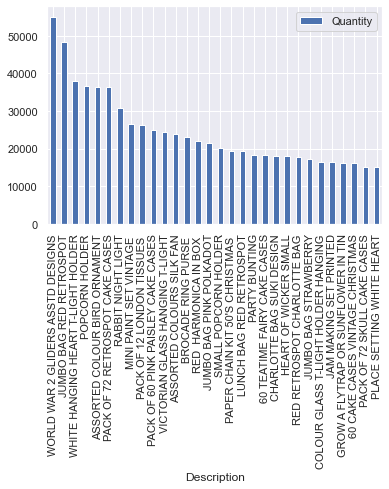

In [86]:
most_popular.head(30).plot(kind = "bar")

In [87]:
data[data["StockCode"]=="22197"].value_counts("Description")

Description
POPCORN HOLDER          803
SMALL POPCORN HOLDER    589
dtype: int64

## Part 2

In [90]:
data1 = data.head(10000)

In [95]:
data["InvoiceNo"].nunique()

20548

In [101]:
test = pd.DataFrame(data["InvoiceNo"].value_counts())

In [105]:
test[test["InvoiceNo"]>1]

,InvoiceNo
573585,1109
581219,748
581492,730
580729,720
558475,703
...,...
550663,2
562920,2
556498,2
575925,2


In [145]:
df = data[["InvoiceNo","StockCode"]]
df["flag"] = 1
df

C:\Users\scro\AppData\Local\Temp\ipykernel_19840\2240055923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["flag"] = 1


,InvoiceNo,StockCode,flag
0,536365,85123A,1
1,536365,71053,1
2,536365,84406B,1
3,536365,84029G,1
4,536365,84029E,1
...,...,...,...
541904,581587,22613,1
541905,581587,22899,1
541906,581587,23254,1
541907,581587,23255,1


In [190]:
price_utility_matrix = df.pivot_table(index='InvoiceNo', columns='StockCode', fill_value=0)
price_utility_matrix

flag                                                           ...  \
StockCode 10002 10080 10120 10123C 10124A 10124G 10125 10133 10135 11001  ...   
InvoiceNo                                                                 ...   
536365        0     0     0      0      0      0     0     0     0     0  ...   
536366        0     0     0      0      0      0     0     0     0     0  ...   
536367        0     0     0      0      0      0     0     0     0     0  ...   
536368        0     0     0      0      0      0     0     0     0     0  ...   
536369        0     0     0      0      0      0     0     0     0     0  ...   
...         ...   ...   ...    ...    ...    ...   ...   ...   ...   ...  ...   
581583        0     0     0      0      0      0     0     0     0     0  ...   
581584        0     0     0      0      0      0     0     0     0     0  ...   
581585        0     0     0      0      0      0     0     0     0     0  ...   
581586        0     0     0      0      0      0     0     0     0     0  ...   
581587        0     0     0      0      0      0     0     0     0     0  ...   

                                                                      \
StockCode DCGS0069 DCGS0070 DCGS0076 DCGSSBOY DCGSSGIRL gift_0001_10   
InvoiceNo                                                              
536365           0        0        0        0         0            0   
536366           0        0        0        0         0            0   
536367           0        0        0        0         0            0   
536368           0        0        0        0         0            0   
536369           0        0        0        0         0            0   
...            ...      ...      ...      ...       ...          ...   
581583           0        0        0        0         0            0   
581584           0        0        0        0         0            0   
581585           0        0        0        0         0            0   
581586           0        0        0        0         0            0   
581587           0        0        0        0         0            0   

                                                               
StockCode gift_0001_20 gift_0001_30 gift_0001_40 gift_0001_50  
InvoiceNo                                                      
536365               0            0            0            0  
536366               0            0            0            0  
536367               0            0            0            0  
536368               0            0            0            0  
536369               0            0            0            0  
...                ...          ...          ...          ...  
581583               0            0            0            0  
581584               0            0            0            0  
581585               0            0            0            0  
581586               0            0            0            0  
581587               0            0            0            0  

[20548 rows x 3932 columns]

In [147]:
test = pd.DataFrame(price_utility_matrix)
test

flag                                                           ...  \
StockCode 10002 10080 10120 10123C 10124A 10124G 10125 10133 10135 11001  ...   
InvoiceNo                                                                 ...   
536365        0     0     0      0      0      0     0     0     0     0  ...   
536366        0     0     0      0      0      0     0     0     0     0  ...   
536367        0     0     0      0      0      0     0     0     0     0  ...   
536368        0     0     0      0      0      0     0     0     0     0  ...   
536369        0     0     0      0      0      0     0     0     0     0  ...   
...         ...   ...   ...    ...    ...    ...   ...   ...   ...   ...  ...   
581583        0     0     0      0      0      0     0     0     0     0  ...   
581584        0     0     0      0      0      0     0     0     0     0  ...   
581585        0     0     0      0      0      0     0     0     0     0  ...   
581586        0     0     0      0      0      0     0     0     0     0  ...   
581587        0     0     0      0      0      0     0     0     0     0  ...   

                                                                      \
StockCode DCGS0069 DCGS0070 DCGS0076 DCGSSBOY DCGSSGIRL gift_0001_10   
InvoiceNo                                                              
536365           0        0        0        0         0            0   
536366           0        0        0        0         0            0   
536367           0        0        0        0         0            0   
536368           0        0        0        0         0            0   
536369           0        0        0        0         0            0   
...            ...      ...      ...      ...       ...          ...   
581583           0        0        0        0         0            0   
581584           0        0        0        0         0            0   
581585           0        0        0        0         0            0   
581586           0        0        0        0         0            0   
581587           0        0        0        0         0            0   

                                                               
StockCode gift_0001_20 gift_0001_30 gift_0001_40 gift_0001_50  
InvoiceNo                                                      
536365               0            0            0            0  
536366               0            0            0            0  
536367               0            0            0            0  
536368               0            0            0            0  
536369               0            0            0            0  
...                ...          ...          ...          ...  
581583               0            0            0            0  
581584               0            0            0            0  
581585               0            0            0            0  
581586               0            0            0            0  
581587               0            0            0            0  

[20548 rows x 3932 columns]

In [148]:
test.iloc[0,:].value_counts()

0    3925
1       7
Name: 536365, dtype: int64

In [138]:
data[data["InvoiceNo"]=="536365"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,2010,12,1,3,Wednesday,False,08:26:00,8,Early Morning,25.50


In [157]:
# price_utility_matrix = data1.pivot_table(values='TotalPrice', index=data1.index, columns='StockCode', fill_value=0)
# price_utility_matrix.head()

In [191]:
price_utility_matrix.shape

(20548, 3932)

In [186]:
type(price_utility_matrix)

pandas.core.frame.DataFrame

In [222]:
X = price_utility_matrix.T
X.head()

InvoiceNo       536365  536366  536367  536368  536369  536370  536371  \
     StockCode                                                           
flag 10002           0       0       0       0       0       1       0   
     10080           0       0       0       0       0       0       0   
     10120           0       0       0       0       0       0       0   
     10123C          0       0       0       0       0       0       0   
     10124A          0       0       0       0       0       0       0   

InvoiceNo       536372  536373  536374  ...  581578  581579  581580  581581  \
     StockCode                          ...                                   
flag 10002           0       0       0  ...       0       0       0       0   
     10080           0       0       0  ...       0       0       0       0   
     10120           0       0       0  ...       0       0       0       0   
     10123C          0       0       0  ...       0       0       0       0   
     10124A          0       0       0  ...       0       0       0       0   

InvoiceNo       581582  581583  581584  581585  581586  581587  
     StockCode                                                  
flag 10002           0       0       0       0       0       0  
     10080           0       0       0       0       0       0  
     10120           0       0       0       0       0       0  
     10123C          0       0       0       0       0       0  
     10124A          0       0       0       0       0       0  

[5 rows x 20548 columns]

In [223]:
X.reset_index(inplace=True)
X.set_index("StockCode",inplace=True)
X.drop("level_0",axis=1,inplace=True)
X

InvoiceNo,536365,536366,536367,536368,536369,536370,536371,536372,536373,536374,...,581578,581579,581580,581581,581582,581583,581584,581585,581586,581587
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10123C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10124A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gift_0001_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gift_0001_20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gift_0001_30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
X1 = X

In [225]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(3932, 10)

In [226]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(3932, 3932)

In [235]:
X.index[999]

'22076'

In [236]:
i = "22076"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

999

In [237]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(3932,)

In [238]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['16258A',
 '20775',
 '20777',
 '20782',
 '21015',
 '21064',
 '21123',
 '21125',
 '21126']

In [305]:
def item_recommender(stockcode):
    
    
    if stockcode in list(X.index):
        l_description = []
        stockcode = str(stockcode)
        product_names = list(X.index)
        product_ID = product_names.index(stockcode)
        correlation_product_ID = correlation_matrix[product_ID]
        Recommend = list(X.index[correlation_product_ID > 0.90])

        # Removes the item already bought by the customer
        Recommend.remove(stockcode) 
        Recommend = Recommend[0:9]
        print(stockcode)
        print(data[data["StockCode"]==stockcode]["Description"].iloc[0])
        print(Recommend)

        for j in Recommend:
            x = data[data["StockCode"]==j]["Description"].iloc[0]
            l_description.append(x)

        return l_description
    
    else:
        print("No Recommendation")

In [303]:
X.index

Index(['10002', '10080', '10120', '10123C', '10124A', '10124G', '10125',
       '10133', '10135', '11001',
       ...
       'DCGS0069', 'DCGS0070', 'DCGS0076', 'DCGSSBOY', 'DCGSSGIRL',
       'gift_0001_10', 'gift_0001_20', 'gift_0001_30', 'gift_0001_40',
       'gift_0001_50'],
      dtype='object', name='StockCode', length=3932)

In [306]:
item_recommender("10002")

10002
INFLATABLE POLITICAL GLOBE 
['17011F', '17012E', '17014A', '18098C', '20681', '20684', '20818', '20835', '20892']


['ORIGAMI SANDLEWOOD INCENSE+FLOWER',
 'ORIGAMI OPIUM INCENSE/CANDLE SET ',
 'ORIGAMI VANILLA INCENSE CONES',
 'PORCELAIN BUTTERFLY OIL BURNER',
 'PINK POLKADOT CHILDRENS UMBRELLA',
 'STRAWBERRY DREAM CHILDS UMBRELLA',
 'GOLD TEDDY BEAR',
 'FRENCH LATTICE CUSHION COVER ',
 'SET/3 TALL GLASS CANDLE HOLDER PINK']

In [307]:
item_recommender("20818")

20818
GOLD TEDDY BEAR
['10002', '17014A', '18098C', '20954', '21002', '21187', '21261', '21279', '21352']


['INFLATABLE POLITICAL GLOBE ',
 'ORIGAMI VANILLA INCENSE CONES',
 'PORCELAIN BUTTERFLY OIL BURNER',
 '*USB Office Mirror Ball',
 'ROSE DU SUD DRAWSTRING BAG',
 'WHITE BELL HONEYCOMB PAPER GARLAND ',
 'GREEN GOOSE FEATHER CHRISTMAS TREE ',
 'VINTAGE KITCHEN PRINT FRUITS',
 'EUCALYPTUS & PINECONE  WREATH']

In [308]:
item_recommender("21261")

21261
GREEN GOOSE FEATHER CHRISTMAS TREE 
['10002', '17011F', '17012E', '17013D', '17014A', '18098C', '20818', '20835', '20892']


['INFLATABLE POLITICAL GLOBE ',
 'ORIGAMI SANDLEWOOD INCENSE+FLOWER',
 'ORIGAMI OPIUM INCENSE/CANDLE SET ',
 'ORIGAMI ROSE INCENSE IN TUBE',
 'ORIGAMI VANILLA INCENSE CONES',
 'PORCELAIN BUTTERFLY OIL BURNER',
 'GOLD TEDDY BEAR',
 'FRENCH LATTICE CUSHION COVER ',
 'SET/3 TALL GLASS CANDLE HOLDER PINK']

In [309]:
item_recommender("17011F")

17011F
ORIGAMI SANDLEWOOD INCENSE+FLOWER
['10002', '17012E', '17013D', '17014A', '18098C', '20835', '20892', '20954', '21069']


['INFLATABLE POLITICAL GLOBE ',
 'ORIGAMI OPIUM INCENSE/CANDLE SET ',
 'ORIGAMI ROSE INCENSE IN TUBE',
 'ORIGAMI VANILLA INCENSE CONES',
 'PORCELAIN BUTTERFLY OIL BURNER',
 'FRENCH LATTICE CUSHION COVER ',
 'SET/3 TALL GLASS CANDLE HOLDER PINK',
 '*USB Office Mirror Ball',
 'VINTAGE BILLBOARD TEA MUG']

In [310]:
item_recommender("21069")

21069
VINTAGE BILLBOARD TEA MUG
['10002', '15060B', '17011F', '17012E', '17013D', '17014A', '18098C', '20681', '20803']


['INFLATABLE POLITICAL GLOBE ',
 'FAIRY CAKE DESIGN UMBRELLA',
 'ORIGAMI SANDLEWOOD INCENSE+FLOWER',
 'ORIGAMI OPIUM INCENSE/CANDLE SET ',
 'ORIGAMI ROSE INCENSE IN TUBE',
 'ORIGAMI VANILLA INCENSE CONES',
 'PORCELAIN BUTTERFLY OIL BURNER',
 'PINK POLKADOT CHILDRENS UMBRELLA',
 'SMALL PINK GLASS SUNDAE DISH']

In [311]:
item_recommender("22076")

22076
6 RIBBONS EMPIRE  
['16258A', '20775', '20777', '20782', '21015', '21064', '21123', '21125', '21126']


['SWIRLY CIRCULAR RUBBERS IN BAG',
 'DAISY NOTEBOOK ',
 'CHRYSANTHEMUM NOTEBOOK',
 'CAMOUFLAGE EAR MUFF HEADPHONES',
 'DARK BIRD HOUSE TREE DECORATION',
 'BOOM BOX SPEAKER BOYS',
 'SET/10 IVORY POLKADOT PARTY CANDLES',
 'SET 6 FOOTBALL CELEBRATION CANDLES',
 'SET OF 6 GIRLS CELEBRATION CANDLES']

In [272]:
data[data["StockCode"]=="22076"]["Description"].iloc[0]

'6 RIBBONS EMPIRE  '

In [239]:
data[data["StockCode"]=="22076"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice
1496,536544,22076,6 RIBBONS EMPIRE,1,2010-12-01 14:32:00,3.36,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon,3.36
5723,536874,22076,6 RIBBONS EMPIRE,1,2010-12-03 11:35:00,1.65,16891.0,United Kingdom,2010,12,3,5,Friday,False,11:35:00,11,Morning,1.65
5763,536876,22076,6 RIBBONS EMPIRE,1,2010-12-03 11:36:00,3.36,NaN,United Kingdom,2010,12,3,5,Friday,False,11:36:00,11,Morning,3.36
6875,536982,22076,6 RIBBONS EMPIRE,1,2010-12-03 14:27:00,4.21,NaN,United Kingdom,2010,12,3,5,Friday,False,14:27:00,14,Noon,4.21
7392,537036,22076,6 RIBBONS EMPIRE,1,2010-12-03 17:28:00,1.65,15545.0,United Kingdom,2010,12,3,5,Friday,False,17:28:00,17,Eve,1.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536563,581219,22076,6 RIBBONS EMPIRE,7,2011-12-08 09:28:00,1.25,NaN,United Kingdom,2011,12,8,4,Thursday,False,09:28:00,9,Morning,8.75
538447,581405,22076,6 RIBBONS EMPIRE,4,2011-12-08 13:50:00,0.39,13521.0,United Kingdom,2011,12,8,4,Thursday,False,13:50:00,13,Noon,1.56
539516,581439,22076,6 RIBBONS EMPIRE,1,2011-12-08 16:30:00,1.25,NaN,United Kingdom,2011,12,8,4,Thursday,False,16:30:00,16,Noon,1.25
540726,581492,22076,6 RIBBONS EMPIRE,4,2011-12-09 10:03:00,1.25,NaN,United Kingdom,2011,12,9,5,Friday,False,10:03:00,10,Morning,5.00


In [233]:
data[data["StockCode"]=="20857"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice
14122,537462,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,6,2010-12-07 10:06:00,1.65,17228.0,United Kingdom,2010,12,7,2,Tuesday,False,10:06:00,10,Morning,9.90
26312,538508,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,2,2010-12-12 13:32:00,1.65,15998.0,United Kingdom,2010,12,12,7,Sunday,True,13:32:00,13,Noon,3.30
30261,538853,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,2,2010-12-14 13:35:00,1.65,16805.0,United Kingdom,2010,12,14,2,Tuesday,False,13:35:00,13,Noon,3.30
33233,539243,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,1,2010-12-16 13:21:00,1.65,18116.0,United Kingdom,2010,12,16,4,Thursday,False,13:21:00,13,Noon,1.65
45626,540273,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,15,2011-01-06 11:57:00,1.65,17368.0,United Kingdom,2011,1,6,4,Thursday,False,11:57:00,11,Morning,24.75
83404,543306,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,1,2011-02-07 11:56:00,1.65,16686.0,United Kingdom,2011,2,7,1,Monday,False,11:56:00,11,Morning,1.65
91014,544077,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,4,2011-02-15 15:04:00,1.65,14825.0,United Kingdom,2011,2,15,2,Tuesday,False,15:04:00,15,Noon,6.60
93609,544303,20857,BLUE ROSE PATCH PURSE PINK BUTTERFL,1,2011-02-17 13:28:00,1.65,18116.0,United Kingdom,2011,2,17,4,Thursday,False,13:28:00,13,Noon,1.65


## Part 3

In [ ]:
product_descriptions = data[["StockCode","Description"]].dropna()
product_descriptions

In [ ]:
# product_descriptions1 = product_descriptions.head(10000)

product_descriptions1 = product_descriptions.copy()

# product_descriptions1.iloc[:,1]

product_descriptions1["Description"].head(10)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["Description"])
X1

In [ ]:
# # Fitting K-Means to the dataset

# X=X1

# kmeans = KMeans(n_clusters = 50, init = 'k-means++')
# y_kmeans = kmeans.fit_predict(X)
# plt.plot(y_kmeans, ".")
# plt.show()

In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

In [ ]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [ ]:
show_recommendations("easter")

In [ ]:
show_recommendations("car")

In [ ]:
show_recommendations("knife")

In [ ]:
show_recommendations("popcorn")